# Scalar Quantization of Digital Signals

In [538]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import math
import numpy as np

In [554]:
def plot_quantizer(x_plot, y_plot, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_label_coords(1,0.40)
    ax.xaxis.set_label_text('Input')
    ax.yaxis.set_label_coords(0.45,.9)
    ax.yaxis.set_label_text('Output')

    ticks = np.arange(-8, 9, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.grid()
    ax.plot(x_plot, y_plot)

In [1188]:
def plot(x, y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    ax.plot(x, y)

In [943]:
def print_center(x, y, z, n):
    offset = (len(x)-n)//2
    for i in range(n):
        input = int(x[i+offset])
        output = int(y[i+offset])
        recons = int(z[i+offset])
        print(f"{input:>6d} {output:>6d} {recons:>6d}")

## A.  Uniform Quantization

### A.a. Midtread ("round") Quantization

In [1022]:
def midtread_quantizer(x, quantization_step):
    return np.round(x / quantization_step).astype(int)

In [1023]:
def midtread_dequantizer(y, quantization_step):
    return y * quantization_step

#### A.a.1. No quantization ($\Delta=1$)

In [1024]:
quantization_step = 1 # Delta

#### Quantizer

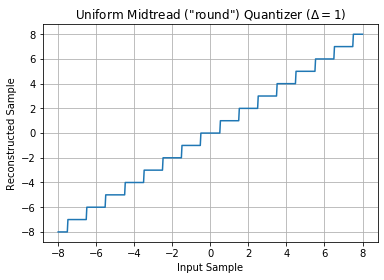

In [1025]:
x = np.linspace(-8, 8, 500) # Input samples
y = midtread_quantizer(x, quantization_step) # Quantized samples
z = midtread_dequantizer(y, quantization_step) # Reconstructed samples
#plot_quantizer(x_plot, y_plot, 'Uniform Midtread ("round") Quantizer with $\Delta={}$'.format(quantization_step))
plot(x, z, "Input Sample", "Reconstructed Sample", "Uniform Midtread (\"round\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Quantization error

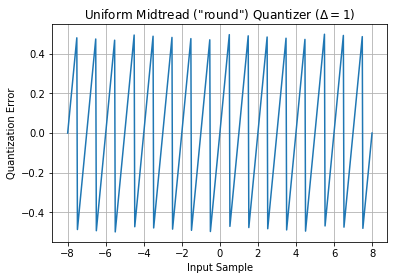

In [1026]:
error = x - z
plot(x, error, "Input Sample", "Quantization Error", "Uniform Midtread (\"round\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Working with signed integers of 16 bits

In [1027]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16)
y = midtread_quantizer(x, quantization_step)
z = midtread_dequantizer(y, quantization_step)

In [1028]:
print(f"{'Input':>6s} {'Output':>6s} {'Recons':>6s}")
print_center(x, y, z, 16)

 Input Output Recons
    -8     -8     -8
    -7     -7     -7
    -6     -6     -6
    -5     -5     -5
    -4     -4     -4
    -3     -3     -3
    -2     -2     -2
    -1     -1     -1
     0      0      0
     1      1      1
     2      2      2
     3      3      3
     4      4      4
     5      5      5
     6      6      6
     7      7      7


In [1029]:
len(np.unique(x, return_counts = True)[0])

65536

In [1030]:
len(np.unique(y, return_counts = True)[0])

65536

Notice that for $\Delta=1$, the number of bits for representing the input and the output is the same: $65536$ different inputs are represented by $65536$ outputs.

#### A.a.2. Quantization with quantization step $\Delta=2$

In [1031]:
quantization_step = 2 # Delta

#### Quantizer

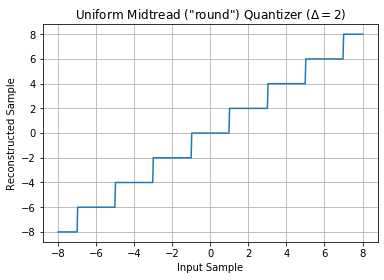

In [1038]:
x = np.linspace(-8, 8, 500)
y = midtread_quantizer(x, quantization_step)
z = midtread_dequantizer(y, quantization_step)
plot(x, z, "Input Sample", "Reconstructed Sample", "Uniform Midtread (\"round\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Quantization error

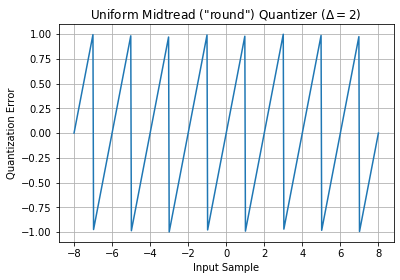

In [1039]:
error = x - z
plot(x, error, "Input Sample", "Quantization Error", "Uniform Midtread (\"round\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Working with signed integers of 16 bits

In [1040]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16)
y = midtread_quantizer(x, quantization_step)
z = midtread_dequantizer(y, quantization_step)

In [1041]:
print(f"{'Input':>6s} {'Output':>6s} {'Recons':>6s}")
print_center(x, y, z, 32)

 Input Output Recons
   -16     -8    -16
   -15     -8    -16
   -14     -7    -14
   -13     -6    -12
   -12     -6    -12
   -11     -6    -12
   -10     -5    -10
    -9     -4     -8
    -8     -4     -8
    -7     -4     -8
    -6     -3     -6
    -5     -2     -4
    -4     -2     -4
    -3     -2     -4
    -2     -1     -2
    -1      0      0
     0      0      0
     1      0      0
     2      1      2
     3      2      4
     4      2      4
     5      2      4
     6      3      6
     7      4      8
     8      4      8
     9      4      8
    10      5     10
    11      6     12
    12      6     12
    13      6     12
    14      7     14
    15      8     16


In [1042]:
len(np.unique(y, return_counts = True)[0])

32769

For $\Delta=2$, a midtread uniform quantizer represents 65536 different inputs with 32769 outputs.

#### A.a.3. Quantization with quantization step $\Delta=3$

In [1043]:
quantization_step = 3

#### Quantizer

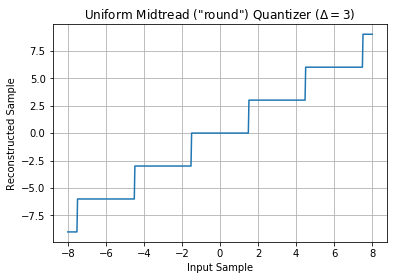

In [1044]:
x = np.linspace(-8, 8, 500)
y = midtread_quantizer(x, quantization_step)
z = midtread_dequantizer(y, quantization_step)
plot(x, z, "Input Sample", "Reconstructed Sample", "Uniform Midtread (\"round\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Quantization error

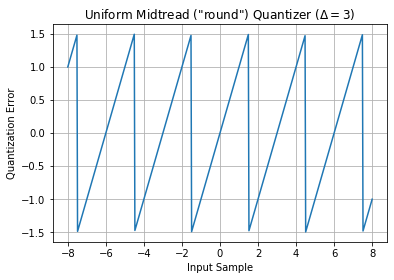

In [1045]:
error = x - z
plot(x, error, "Input Sample", "Quantization Error", "Uniform Midtread (\"round\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Working with signed integers of 16 bits

In [1046]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16)
y = midtread_quantizer(x, quantization_step)
z = midtread_dequantizer(y, quantization_step)

In [1047]:
print_center(x, y, z, 32)

   -16     -5    -15
   -15     -5    -15
   -14     -5    -15
   -13     -4    -12
   -12     -4    -12
   -11     -4    -12
   -10     -3     -9
    -9     -3     -9
    -8     -3     -9
    -7     -2     -6
    -6     -2     -6
    -5     -2     -6
    -4     -1     -3
    -3     -1     -3
    -2     -1     -3
    -1      0      0
     0      0      0
     1      0      0
     2      1      3
     3      1      3
     4      1      3
     5      2      6
     6      2      6
     7      2      6
     8      3      9
     9      3      9
    10      3      9
    11      4     12
    12      4     12
    13      4     12
    14      5     15
    15      5     15


In [1048]:
len(np.unique(y, return_counts = True)[0])

21846

For $\Delta=3$, a midtread uniform quantizer represents 65536 different inputs with 21846 outputs.

### A.a.4. Quantization with $\Delta=4$

In [1049]:
quantization_step = 4 # Delta

#### Quantizer

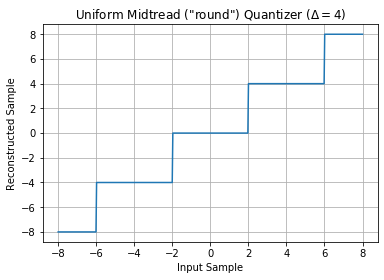

In [1050]:
x = np.linspace(-8, 8, 500)
y = midtread_quantizer(x, quantization_step)
z = midtread_dequantizer(y, quantization_step)
plot(x, z, "Input Sample", "Reconstructed Sample", "Uniform Midtread (\"round\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Quantization error

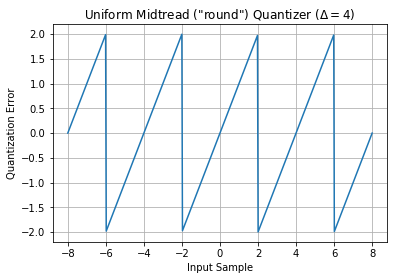

In [1051]:
error = x - z
plot(x, error, "Input Sample", "Quantization Error", "Uniform Midtread (\"round\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Working with signed integers of 16 bits

In [1052]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16)
y = midtread_quantizer(x, quantization_step)
z = midtread_dequantizer(y, quantization_step)

In [1053]:
print(f"{'Input':>6s} {'Output':>6s} {'Recons':>6s}")
print_center(x, y, z, 32)

 Input Output Recons
   -16     -4    -16
   -15     -4    -16
   -14     -4    -16
   -13     -3    -12
   -12     -3    -12
   -11     -3    -12
   -10     -2     -8
    -9     -2     -8
    -8     -2     -8
    -7     -2     -8
    -6     -2     -8
    -5     -1     -4
    -4     -1     -4
    -3     -1     -4
    -2      0      0
    -1      0      0
     0      0      0
     1      0      0
     2      0      0
     3      1      4
     4      1      4
     5      1      4
     6      2      8
     7      2      8
     8      2      8
     9      2      8
    10      2      8
    11      3     12
    12      3     12
    13      3     12
    14      4     16
    15      4     16


In [1054]:
len(np.unique(y, return_counts = True)[0])

16385

For $\Delta=1$, $65536$ different values are represented by $16385$ values.

### A.b. Deadzone ("truncation") Quantization

In [1055]:
def deadzone_quantizer(x, quantization_step):
    return (x / quantization_step).astype(np.int)

In [1056]:
def deadzone_dequantizer(y, quantization_step):
    return y * quantization_step

#### A.b.1. Quantization with $\Delta=2$

In [1057]:
quantization_step = 2 # Delta

#### Quantizer

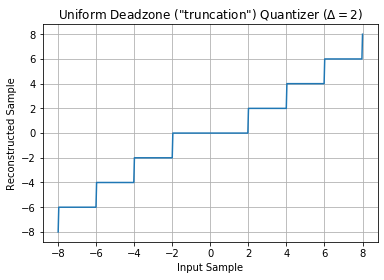

In [1058]:
x = np.linspace(-8, 8, 500) # Input samples
y = deadzone_quantizer(x, quantization_step) # Quantized samples
z = deadzone_dequantizer(y, quantization_step) # Reconstructed samples
plot(x, z, "Input Sample", "Reconstructed Sample", "Uniform Deadzone (\"truncation\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Quantization error

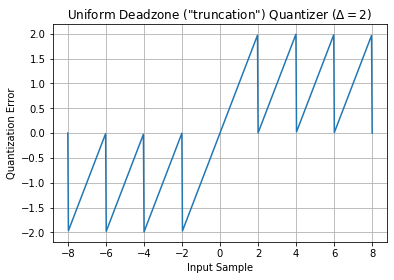

In [1060]:
error = x - z
plot(x, error, "Input Sample", "Quantization Error", "Uniform Deadzone (\"truncation\") Quantizer ($\Delta={}$)".format(quantization_step))

#### Compute output for each possible input using 16 bits

In [1064]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16)
y = deadzone_quantizer(x, quantization_step)
z = midtread_dequantizer(y, quantization_step)

In [1065]:
print_center(x, y, z, 32)

   -16     -8    -16
   -15     -7    -14
   -14     -7    -14
   -13     -6    -12
   -12     -6    -12
   -11     -5    -10
   -10     -5    -10
    -9     -4     -8
    -8     -4     -8
    -7     -3     -6
    -6     -3     -6
    -5     -2     -4
    -4     -2     -4
    -3     -1     -2
    -2     -1     -2
    -1      0      0
     0      0      0
     1      0      0
     2      1      2
     3      1      2
     4      2      4
     5      2      4
     6      3      6
     7      3      6
     8      4      8
     9      4      8
    10      5     10
    11      5     10
    12      6     12
    13      6     12
    14      7     14
    15      7     14


In [1066]:
len(np.unique(y, return_counts = True)[0])

32768

Using $\Delta=2$, a deadzone quantizer represents 65536 samples with 32768 representation levels.

## B. Companded (COMpressed + exPANDED) Quantization

In [1067]:
def muLaw_compress(x, mu):
    return np.log(1+mu*np.abs(x))/np.log(1+mu)*np.sign(x)

In [1068]:
def muLaw_expand(y, mu):
    return (1/mu)*(((1+mu)**np.abs(y))-1)*np.sign(y)

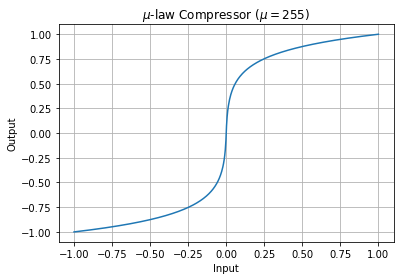

In [1069]:
x = np.linspace(-1, 1, 500)

mu = 255
y = muLaw_compress(x, mu)
plot(x, y, "Input", "Output", "$\mu$-law Compressor ($\mu={}$)".format(mu))

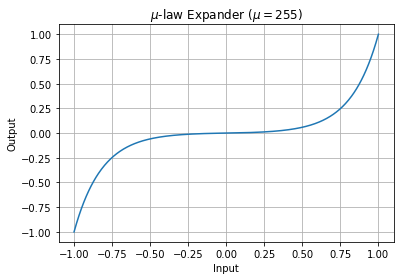

In [1070]:
x = np.linspace(-1, 1, 500)

mu = 255
y = muLaw_expand(x, mu)
plot(x, y, "Input", "Output", "$\mu$-law Expander ($\mu={}$)".format(mu))

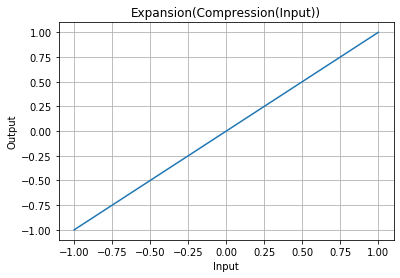

In [1071]:
mu = 255
x = np.linspace(-1, 1, 500)
y = muLaw_compress(x, mu)
x_recons = muLaw_expand(y, mu)
plot(x, x_recons, "Input", "Output", "Expansion(Compression(Input))".format(mu))

#### Companded Deadzone Quantizer using $2^16$ inputs

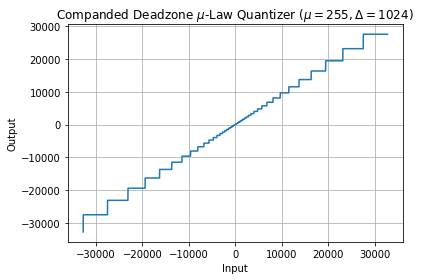

In [1162]:
mu = 255
quantization_step = 1024
x = np.linspace(-32768, 32767, 65536)
x_compressed = (32768*(muLaw_compress(x/32768, mu)))
y = deadzone_quantizer(x_compressed, quantization_step)
z_compressed = deadzone_dequantizer(y, quantization_step)
#z_compressed = midtread_dequantizer(y, quantization_step)
z = np.round(32768*muLaw_expand(z_compressed/32768, mu)).astype(np.int16)
plot(x, z, "Input", "Output", "Companded Deadzone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, quantization_step))

#### Quantization error

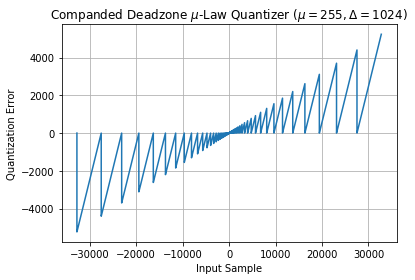

In [1164]:
error = x - z
plot(x, error, "Input Sample", "Quantization Error", "Companded Deadzone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, quantization_step))

In [1169]:
mu = 255
quantization_step = 128
x = np.linspace(-32768, 32767, 65536)
x_compressed = (32768*(muLaw_compress(x/32768, mu)))
y = deadzone_quantizer(x_compressed, quantization_step)
z_compressed = deadzone_dequantizer(y, quantization_step)
z = np.round(32768*muLaw_expand(z_compressed/32768, mu)).astype(np.int16)
print(f"{'Input':>6s} {'Output':>6s} {'Recons':>6s}")
print_center(x, y, z, 32)

 Input Output Recons
   -16     -5    -15
   -15     -5    -15
   -14     -4    -12
   -13     -4    -12
   -12     -4    -12
   -11     -3     -9
   -10     -3     -9
    -9     -3     -9
    -8     -2     -6
    -7     -2     -6
    -6     -2     -6
    -5     -1     -3
    -4     -1     -3
    -3     -1     -3
    -2      0      0
    -1      0      0
     0      0      0
     1      0      0
     2      0      0
     3      1      3
     4      1      3
     5      1      3
     6      2      6
     7      2      6
     8      2      6
     9      3      9
    10      3      9
    11      3      9
    12      4     12
    13      4     12
    14      4     12
    15      5     15


In [1166]:
len(np.unique(y, return_counts = True)[0])

512

For $\Delta=128$, a companded deadzone $\mu$-law quantizer represents a 16-bits input sample with only one of 512 possible representation levels (9 bits/output), but notice that at the center of the dynamic range (which corresponds to the input samples that are closer to 0) the quantization error is smaller than 3, except for the deadzone in which the quantization error is smaller that 5.

# Which performs better?

In [1089]:
def average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)

In [1090]:
def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(average_energy(error_signal))

In [1312]:
def log_average_energy(x):
    return np.sum(np.log(x.astype(np.double)*x.astype(np.double)+1))/len(x)

In [1313]:
def log_RMSE(x, y):
    error_signal = x - y
    return math.sqrt(log_average_energy(error_signal))

In [1091]:
# Based on https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python
def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

In [1116]:
def midtread_quantization(x, quantization_step):
    y = midtread_quantizer(x, quantization_step)
    z = midtread_dequantizer(y, quantization_step)
    return y, z

In [1117]:
def deadzone_quantization(x, quantization_step):
    y = deadzone_quantizer(x, quantization_step)
    z = deadzone_dequantizer(y, quantization_step)
    return y, z

In [1284]:
def companded_quantization(x, quantization_step):
    mu = 255
    x_compressed = (32768*(muLaw_compress(x/32768, mu)))
    y = deadzone_quantizer(x_compressed, quantization_step)
    #y = midtread_quantizer(x_compressed, quantization_step)
    z_compressed = deadzone_dequantizer(y, quantization_step)
    z = np.round(32768*muLaw_expand(z_compressed/32768, mu)).astype(np.int16)
    return y, z

In [1357]:
def RD_curve(x, quantization):
    RD_points = []
    for i in range(1, 32768, 32):
        y, z = quantization(x, i)
        rate = entropy_in_bits_per_symbol(y)
        distortion = log_RMSE(x, z)
        RD_points.append((rate, distortion))
    return RD_points

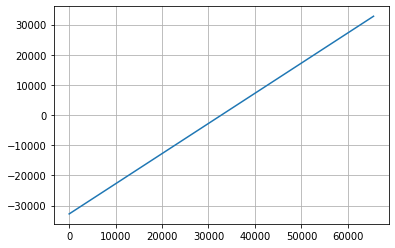

In [1358]:
x = np.linspace(-32768, 32767, 65536).astype(np.int16)
plot(np.linspace(0,65535, 65536).astype(np.int), x)

In [1359]:
midtread_RD_points = RD_curve(x, midtread_quantization)
deadzone_RD_points = RD_curve(x, deadzone_quantization)
companded_RD_points = RD_curve(x, companded_quantization)

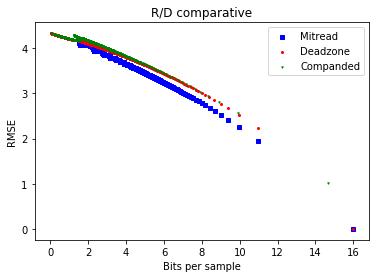

In [1363]:
plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("RMSE")
#plt.xscale("log")
plt.scatter(*zip(*midtread_RD_points), s=12, c='b', marker="s", label='Mitread')
plt.scatter(*zip(*deadzone_RD_points), s=4, c='r', marker="o", label='Deadzone')
plt.scatter(*zip(*companded_RD_points), s=2, c='g', marker="v", label='Companded')
plt.legend(loc='upper right')
plt.show()

# Which performs better for an audio signal?

In [1364]:
import sounddevice as sd
fs = 44100
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype=np.int16)
print("Speak!")
while sd.wait():
    pass
print("done")

Speak!
done


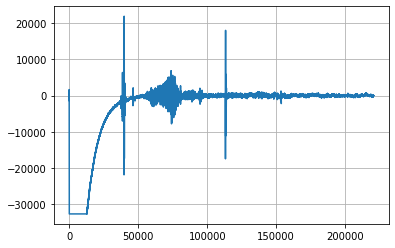

In [1365]:
plot(np.linspace(0, len(x)-1, len(x)), x)

In [1366]:
sd.play(x)

In [1367]:
midtread_RD_points = RD_curve(x, midtread_quantization)
deadzone_RD_points = RD_curve(x, deadzone_quantization)
companded_RD_points = RD_curve(x, companded_quantization)

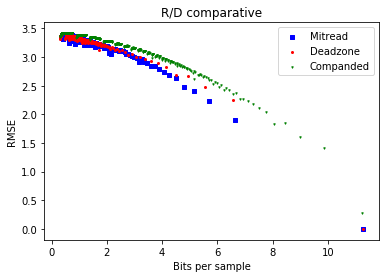

In [1368]:
plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("RMSE")
#plt.xscale("log")
plt.scatter(*zip(*midtread_RD_points), s=12, c='b', marker="s", label='Mitread')
plt.scatter(*zip(*deadzone_RD_points), s=4, c='r', marker="o", label='Deadzone')
plt.scatter(*zip(*companded_RD_points), s=2, c='g', marker="v", label='Companded')
plt.legend(loc='upper right')
plt.show()

In [1324]:
x = np.linspace(-50, 50, 20).astype(np.int16)

In [1325]:
midtread_RD_points = RD_curve(x, midtread_quantization)
deadzone_RD_points = RD_curve(x, deadzone_quantization)
companded_RD_points = RD_curve(x, companded_quantization)

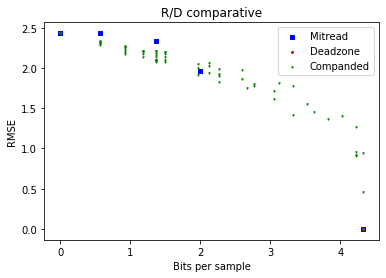

In [1326]:
plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("RMSE")
plt.scatter(*zip(*midtread_RD_points), s=12, c='b', marker="s", label='Mitread')
plt.scatter(*zip(*deadzone_RD_points), s=4, c='r', marker="o", label='Deadzone')
plt.scatter(*zip(*companded_RD_points), s=2, c='g', marker="v", label='Companded')
plt.legend(loc='upper right')
plt.show()

In [1333]:
import sounddevice as sd
fs = 44100
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype=np.int16)
print("Speak!")
while sd.wait():
    pass
print("done")

Speak!
done


In [1376]:
#y, z = midtread_quantization(x, 100)
#y, z = companded_quantization(x, 1000)
y, z = deadzone_quantization(x, 1000)
z = z.astype(np.int16)
sd.play(x)
x

array([[ 12],
       [-34],
       [ 57],
       ...,
       [-57],
       [-88],
       [-94]], dtype=int16)

In [1377]:
y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [1378]:
sd.play(z)
z

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int16)

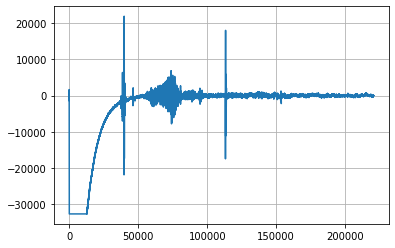

In [1379]:
plot(np.linspace(0,len(z)-1,len(z)), x)

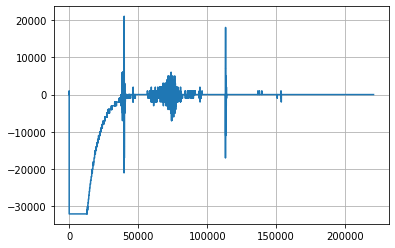

In [1380]:
plot(np.linspace(0,len(z)-1,len(z)), z)

In [1381]:
RMSE(x, z)

405.2593557178235

In [1382]:
log_RMSE(x, z)

3.2368019916649517

In [199]:

def SNR(x, y):
    signal_energy = compute_average_energy(x)
    error_energy = compute_average_energy(x-y)
    print("signal energy =", signal_energy)
    print("error energy =", error_energy)
    return 10*math.log(signal_energy/error_energy)